In [1]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pickle

In [2]:
#### Preprocecing ###

In [3]:
jh_dir = "../../COVID-19"

In [4]:
Confirmed = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [5]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df
confirmed = confirmed.cummax()

In [6]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.cummax()

In [7]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.cummax()

In [8]:
### Data Preparation ###

In [9]:
country = 'Japan'
epoch = pd.to_datetime('2020-02-01')
last = pd.to_datetime('2020-04-19')
C0 = confirmed.loc[epoch:last, country].values
R0 = (recovered).loc[epoch:last, country].values
D0 = death.loc[epoch:last, country].values
P = 12000_0000
iteration=2000
repeat = 1000

In [10]:
data = {'T': C0.shape[0], 'T0': C0.shape[0], 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}

In [11]:
### Model ###

In [12]:
sm_1 = pystan.StanModel(file="single-step.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6a0421c1e1d04e77165a1a1f8de2e034 NOW.


In [13]:
sm_const = pystan.StanModel(file="const.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d76821a1f0fb1a5cb761979efd9cc19 NOW.


In [16]:
# Train the model and generate samples
fit_1 = sm_1.sampling(data=data, iter=iteration, init='random', control={'adapt_delta':0.99999})
fit_1


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_6a0421c1e1d04e77165a1a1f8de2e034.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf  11.12    0.11   2.28   7.12   9.44  10.95  12.65  15.88    458   1.01
b0         0.44    0.02   0.26   0.05   0.22   0.39   0.64   0.94    133   1.03
b1         0.33    0.02   0.22   0.03   0.15   0.29   0.49   0.83    172   1.03
theta_b    0.82    0.09   0.98 2.4e-3   0.15   0.49   1.15   3.45    114   1.05
b_date    53.53    4.84  16.41   31.1  38.33  50.58  70.74  78.35     11   1.14
p          0.27    0.01   0.18   0.09   0.14   0.21   0.34   0.79    145   1.02
q0         0.94  5.3e-3   0.06   0.77   0.91   0.96   0.98    1.0    128   1.03
q1          0.6    0.07   0.19    0.3   0.43   0.62   0.75   0.94      7   1.46
theta_q     1.1    0.05   0.88   0.15   0.47   0.86

In [59]:
# Train the model and generate samples
fit_const = sm_const.sampling(data=data, iter=iteration, init='random')
fit_const


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_6d76821a1f0fb1a5cb761979efd9cc19.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     12.38    0.03   2.39   8.24  10.71  12.19  13.85   17.6   8049    1.0
b             0.31  1.9e-3   0.24   0.04   0.12   0.24   0.45    0.9  15552    1.0
p             0.35  1.9e-3   0.23   0.09   0.16   0.29    0.5    0.9  14150    1.0
q             0.93  2.7e-3   0.07   0.76   0.89   0.94   0.98    1.0    579   1.01
NI[1]         0.93  5.0e-3   0.66   0.05   0.41   0.82   1.32   2.46  17453    1.0
NI[2]         0.98  5.5e-3    0.7   0.04   0.42   0.86   1.39   2.63  16194    1.0
NI[3]         1.94  7.1e-3   0.81    0.6   1.34   1.86   2.44   3.73  13017    1.0
NI[4]         1.12  6.2e-3   0.81   0.05   0.48   0.97   1.59   3.02  16717    1.0
NI[5]         1.19  6.

In [ ]:
# Save models

In [ ]:
## Saving results

In [61]:
import pickle
with open("sm1_fit.pkl", "wb") as f:
    pickle.dump({'model' : sm_1, 'fit' : fit_1}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [62]:
import pickle
with open("sm_const_fit.pkl", "wb") as f:
    pickle.dump({'model' : sm_const, 'fit' : fit_const}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
### Load modesl

In [ ]:
with open("sm1_fit.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_1 = data_dict['model']
fit_start_1 = data_dict['fit']
# fit = data_list[1]

In [ ]:
# with open("sm2_fit.pkl", "rb") as f:
#     data_dict = pickle.load(f)
#     # or with a list
#     # data_list = pickle.load(f)
# sm_2 = data_dict['model']
# fit_start_2 = data_dict['fit']
# # fit = data_list[1]

In [ ]:
with open("sm_const_fit.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_const = data_dict['model']
fit_const = data_dict['fit']
# fit = data_list[1]

In [ ]:
### Convergence

In [17]:
#data_const = az.from_pystan(fit_const, log_likelihood='log_lik')
data_1 = az.from_pystan(fit_1, log_likelihood='log_lik')

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6b1e8b7d0>,
      dtype=object)

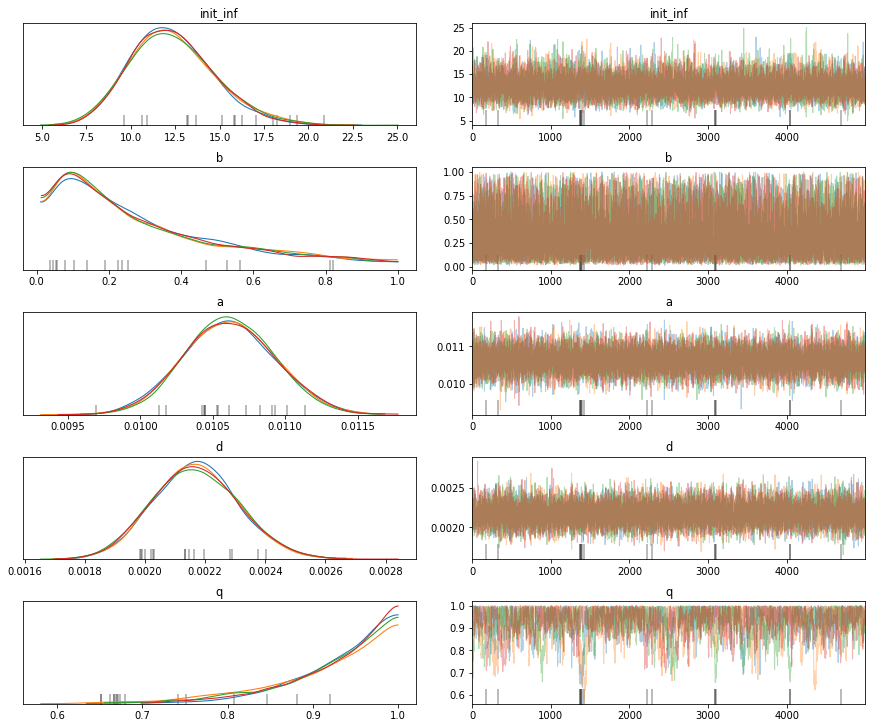

In [64]:
az.plot_trace(data_const, var_names=['init_inf', 'b', 'a', 'd', 'q'])

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f97c94501d0>,
      dtype=object)

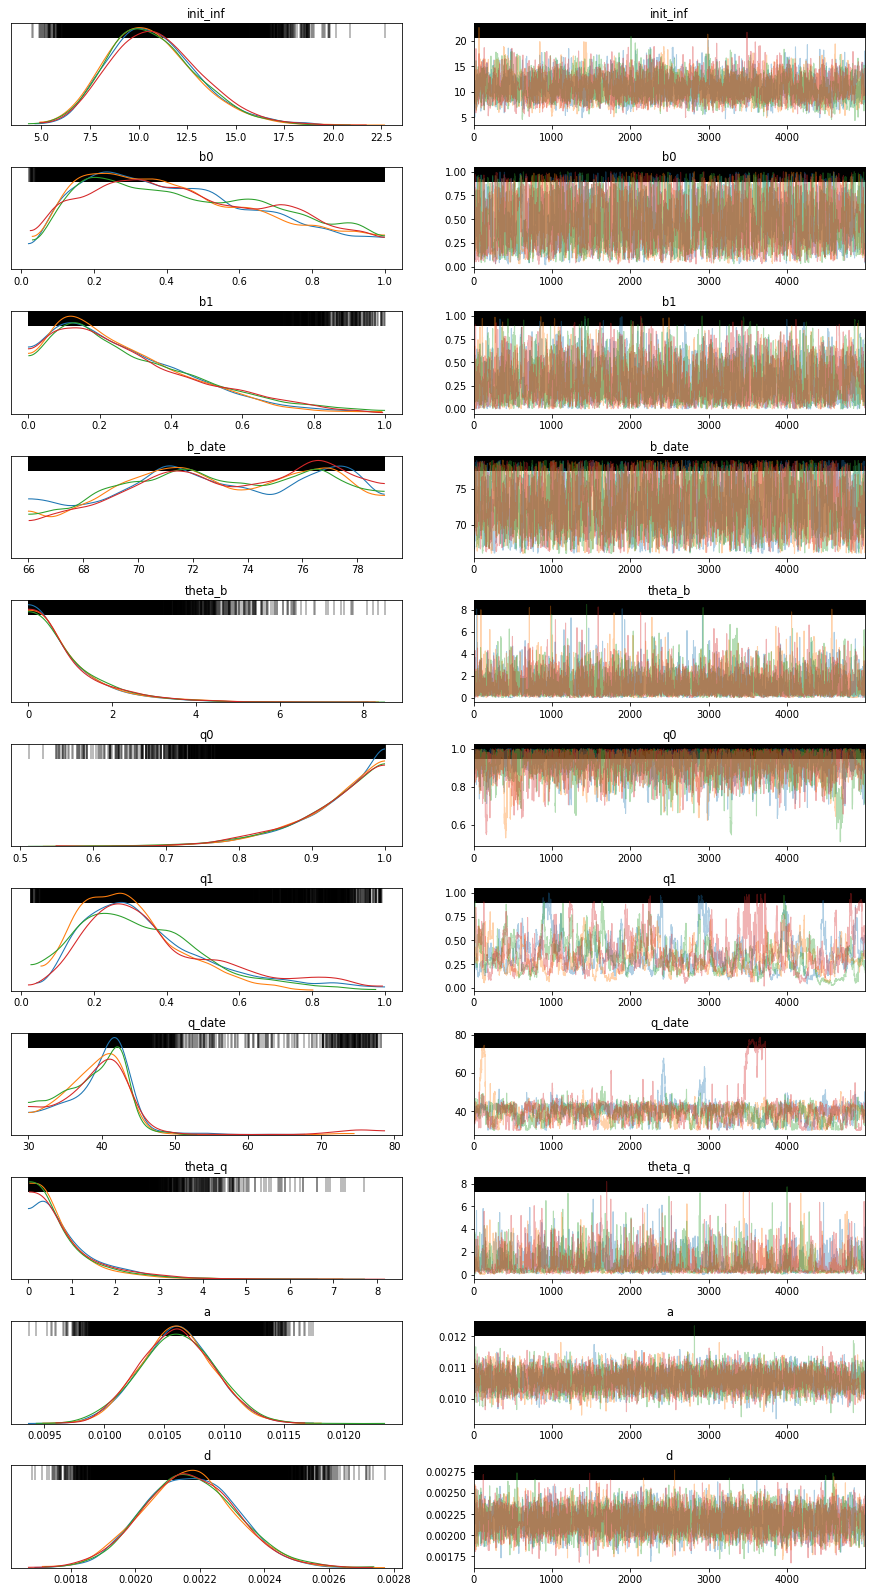

In [22]:
az.plot_trace(data_1, var_names=['init_inf', 'b0', 'b1', 'b_date', 'theta_b', 'q0', 'q1', 'q_date', 'theta_q', 'a', 'd'], divergences='top')

In [19]:
data_1

Inference data with groups:
	> posterior
	> sample_stats

In [ ]:
## Validation by simulation

In [66]:
def sigmoid(x, theta, t0):
    return 1/(1 + np.exp(-theta*(x-t0)))

In [ ]:
def simulate(init_inf, b0, b1, theta_b, b_date, q0, q1, theta_q, q_date,
             a, d, horizon):
    S = init_inf;
    R = 0;
    D = 0;
    S_list = [S]
    NI_list = [0]
    R_list = [R]
    D_list = [D]
    b_list = [b0]
    q_list = [0]
    q = q0 + (q1 - q0) * sigmoid(0, theta_q, q_date)
    S0 = [scipy.stats.poisson.rvs(q*init_inf)]
    R0 = [scipy.stats.poisson.rvs(a * S0[0])]
    D0 = [scipy.stats.poisson.rvs(d * S0[0])]
    for t in range(horizon):
        b = b0 + (b1-b0) * sigmoid(t, theta_b, b_date)
        growth = (1 - pow(1- p, b * I / (P - D))) * (P - C);
        NI = scipy.stats.poisson.rvs(a * S0[0])
        q = q0 + (q1 - q0) * sigmoid(t, theta_q, q_date)
        NR = scipy.stats.poisson.rvs(a * (S - R - D))
        ND = scipy.stats.poisson.rvs(d * (S - R - D))
        D = D + ND
        S = S + I
        R = R + NR
        S_list.append(S)
        R_list.append(R)
        D_list.append(D)
        b_list.append(b)
        q_list.append(q)
        NI0 = scipy.stats.poisson.rvs(q*I)
        NR0 = scipy.stats.poisson.rvs(a * (S0[-1] - R0[-1] - D0[-1]))
        ND0 = scipy.stats.poisson.rvs(d * (S0[-1] - R0[-1] - D0[-1]))
        S0.append(S0[-1]+NI0)
        R0.append(R0[-1]+NR0)
        D0.append(D0[-1]+ND0)
    data = pd.DataFrame({'S':np.array(S_list),
                        'R':np.array(R_list),
                        'D':np.array(D_list),
                        'b':np.array(b_list),
                        'q':np.array(q_list),
                        'S0':np.array(S0),
                        'R0':np.array(R0),
                        'D0':np.array(D0)},
                        index=pd.date_range(start=epoch, periods=horizon+1, freq='D'))
    return data

In [ ]:
i = 1
fit = fit_start_1
horizon=(pd.to_datetime('2020-04-18') - pd.to_datetime('2020-02-01')).days
df = simulate(init_inf=fit['init_inf'][i],
                      b0=fit['b0'][i],
                      b1=fit['b1'][i],
                      theta_b=fit['theta_b'][i],
                      b_date=fit['b_date'][i],
                      q0=fit['q0'][i],
                      q1=fit['q1'][i],
                      theta_q=fit['theta_q'][i],
                      q_date=fit['q_date'][i],
                      a=fit['a'][i],
                      d=fit['d'][i],
                      horizon=horizon)
df['S0']

In [ ]:
C0S = df['S0'].values
R0S = df['R0'].values
D0S = df['D0'].values
data_simulated = {'T': C0S.shape[0], 'T0': C0S.shape[0], 'P': P, 'C0': C0S, 'R0': R0S, 'D0':D0S}

In [ ]:
# Train the model and generate samples
fit_simulated = sm_1.sampling(data=data_simulated, iter=iteration, init=0)
fit_simulated

In [ ]:
(fit_start_1['init_inf'][i], fit_start_1['b0'][i], fit_start_1['b1'][i], fit_start_1['theta_b'][i], 
fit_start_1['b_date'][i], fit_start_1['q0'][i], fit_start_1['q1'][i], fit_start_1['theta_q'][i], fit_start_1['q_date'][7]
,fit_start_1['a'][i], fit_start_1['d'][i])

In [ ]:
### Visualization ###

In [ ]:
def monte_carlo(fit, horizon):
    S = pd.DataFrame()
    R = pd.DataFrame()
    D = pd.DataFrame()
    b = pd.DataFrame()
    q = pd.DataFrame()
    S0 = pd.DataFrame()
    R0 = pd.DataFrame()
    I0 = pd.DataFrame()
    D0 = pd.DataFrame()
    n = fit['init_inf'].shape[0]
    for k in range(repeat):
        i = np.random.randint(n)
        try:
            q0 = fit['q0'][i]
        except:
            q0 = 0
        
        df = simulate(init_inf=fit['init_inf'][i],
                      b0=fit['b0'][i],
                      b1=fit['b1'][i],
                      theta_b=fit['theta_b'][i],
                      b_date=fit['b_date'][i],
                      q0=q0,
                      q1=fit['q1'][i],
                      theta_q=fit['theta_q'][i],
                      q_date=fit['q_date'][i],
                      a=fit['a'][i],
                      d=fit['d'][i],
                      horizon=horizon)
        S = pd.concat([S, df['S']], axis=1)
        R = pd.concat([R, df['R']], axis=1)
        D = pd.concat([D, df['D']], axis=1)
        b = pd.concat([b, df['b']], axis=1)
        q = pd.concat([q, df['q']], axis=1)
        S0 = pd.concat([S0, df['S0']], axis=1)
        R0 = pd.concat([R0, df['R0']], axis=1)
        D0 = pd.concat([D0, df['D0']], axis=1)
        I0 = pd.concat([I0, df['S0'] - df['R0']], axis=1)
    return S, R, D, b, q, S0, R0, I0, D0
    

In [ ]:
def extract_series(fit, name):
    value_list = []
    for d in range(S0.shape[0]):
        vals = fit['{}[{}]'.format(name, d+1)]
        value_list.append(vals)
    data = np.array(value_list)
    return pd.DataFrame(data, 
                        index=confirmed.index)

In [ ]:
def draw(simulated, real=None, upto=pd.to_datetime('2020-04-18')):
    graph=pd.DataFrame(index=pd.date_range(start=epoch, end=upto))
    simulated = simulated.dropna(axis=1)
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", data=graph, aspect=2)

In [ ]:
S, R, D, b, q, S0S, R0S, I0S, D0S = monte_carlo(fit_start_1, 120)

In [ ]:
draw(I0S, real=(confirmed-recovered)[country])

In [ ]:
S.median(axis=1)[pd.to_datetime('2020-04-18')]

In [ ]:
draw(q)

In [ ]:
draw(b)

In [ ]:
draw(R0S, real=recovered[country])

In [ ]:
draw(D0S, real=death[country])

In [ ]:
draw(S, upto=pd.to_datetime('2020-05-30'))

In [ ]:
draw(D, upto=pd.to_datetime('2020-05-30'))

In [ ]:
### model selection

In [ ]:
az.loo(data_const)

In [ ]:
az.loo(data_1)

In [ ]:
az.compare({'const':data_const, '1-step':data_1})

In [ ]:
az.loo(data_1, pointwise=True)

In [ ]:
az.loo(data_const, pointwise=True)

In [ ]:
data_CV = {'T': C0.shape[0], 'T0': 50, 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}

In [ ]:
# Train the model and generate samples
fit_1_CV = sm_1.sampling(data=data_CV, iter=iteration, init=0)


In [ ]:
v_log_lik = fit_1_CV['v_log_lik']
v_log_lik[~np.isnan(v_log_lik)].mean()

In [ ]:
# Train the model and generate samples
fit_const_CV = sm_const.sampling(data=data_CV, iter=iteration, init=0)
fit_const_CV['v_log_lik'].mean()

In [ ]:
fit_1_CV

In [ ]:
fit_const_CV